In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')
import gc

## Прочтём данные

In [25]:
df_sub=pd.read_csv("sample_submission.csv")
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")

## Исследование и предварительная обработка

In [11]:
train_data.shape, test_data.shape, sample_data.shape

((188533, 13), (125690, 12), (125690, 2))

In [15]:
train_data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [27]:
test_data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [14]:
train_data.describe()

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


In [28]:
test_data.describe()

,id,model_year,milage
count,125690.000000,125690.000000,125690.000000
mean,251377.500000,2015.797526,66042.581510
std,36283.722005,5.673797,50223.858435
min,188533.000000,1974.000000,100.000000
25%,219955.250000,2013.000000,24500.000000
50%,251377.500000,2017.000000,57500.000000
75%,282799.750000,2020.000000,95798.000000
max,314222.000000,2024.000000,405000.000000


In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [30]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


In [ ]:
df_train = df_train.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])

- Пропуски в тренировочных данных

In [34]:
df_train.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

- Пропуски в тестовых данных

In [35]:
df_test.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

Посмторим на распределение цены средней цены автомобиля в зависимости от его марки

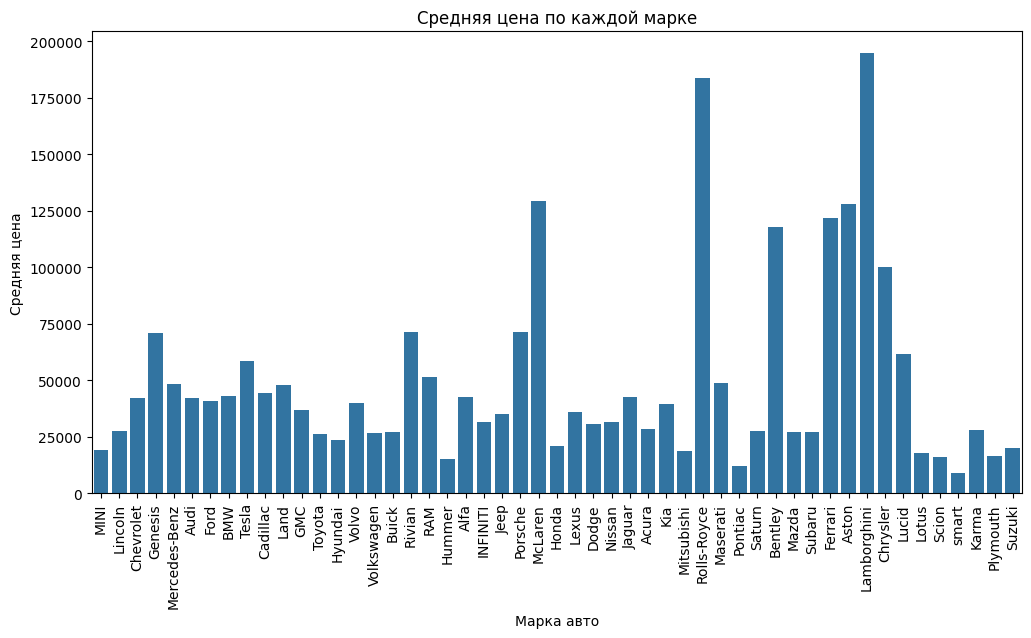

In [43]:
plt.figure(figsize=(12, 6))
sns.barplot(x='brand', y='price', data=df_train[:10000], errorbar=None)
plt.title('Средняя цена по каждой марке')
plt.xlabel('Марка авто')
plt.ylabel('Средняя цена')
plt.xticks(rotation=90)  
plt.show()

Посмотрим как отличаются средние цены автомобилей побывавших в ДТП

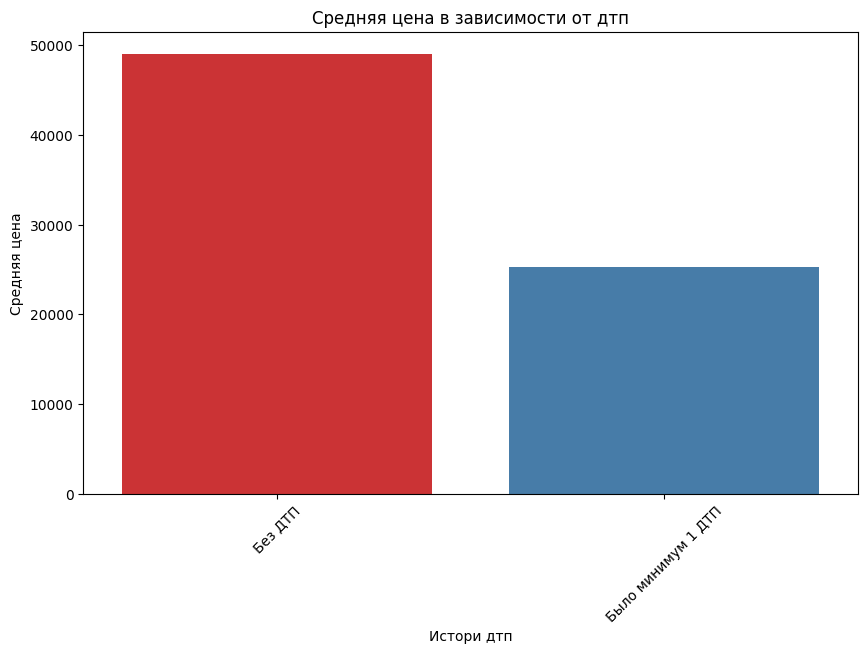

In [54]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='accident', y='price', data=df_train, errorbar=None, palette='Set1')
plt.title('Средняя цена в зависимости от дтп')
plt.xlabel('Истори дтп')
plt.ylabel('Средняя цена')
plt.xticks(rotation=45)

new_labels = ['Без ДТП', 'Было минимум 1 ДТП'] 
ax.set_xticklabels(new_labels)

plt.show()

Посмотрим как распределяются автомобилей по типу топлива

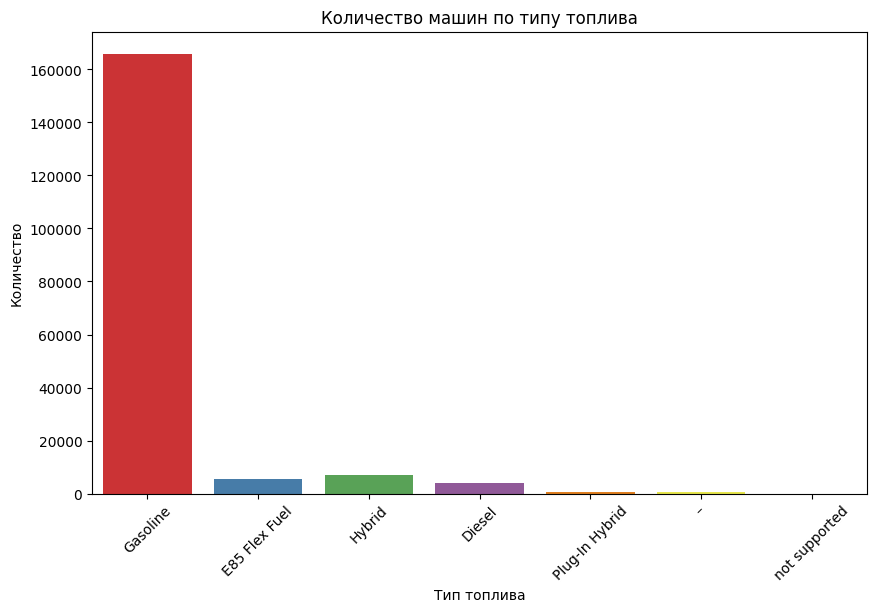

In [55]:
plt.figure(figsize=(10, 6))
sns.countplot(x='fuel_type', data=df_train, palette='Set1')
plt.title('Количество машин по типу топлива')
plt.xlabel('Тип топлива')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

- Уникальные значения признаков

In [58]:
categorical_columns = df_test.select_dtypes(include=['object']).columns
unique_values = {col: df_test[col].nunique() for col in categorical_columns}
for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")
    
gc.collect()

brand: 55 unique values
model: 1891 unique values
fuel_type: 7 unique values
engine: 1117 unique values
transmission: 52 unique values
ext_col: 317 unique values
int_col: 156 unique values
accident: 2 unique values
clean_title: 1 unique values


15286

In [61]:
missing_train = df_train.isna().mean() * 100
missing_test = df_test.isna().mean() * 100

print("Признаки в тренировочном датасете с более чем 10 % пропусков:")
print(missing_train[missing_train > 10])

print("\nПризнаки в тестовом датасете с более чем 10 % пропусков:")
print(missing_test[missing_test > 10])

Признаки в тренировочном датасете с более чем 10 % пропусков:
clean_title    11.360876
dtype: float64

Признаки в тестовом датасете с более чем 10 % пропусков:
clean_title    11.328666
dtype: float64


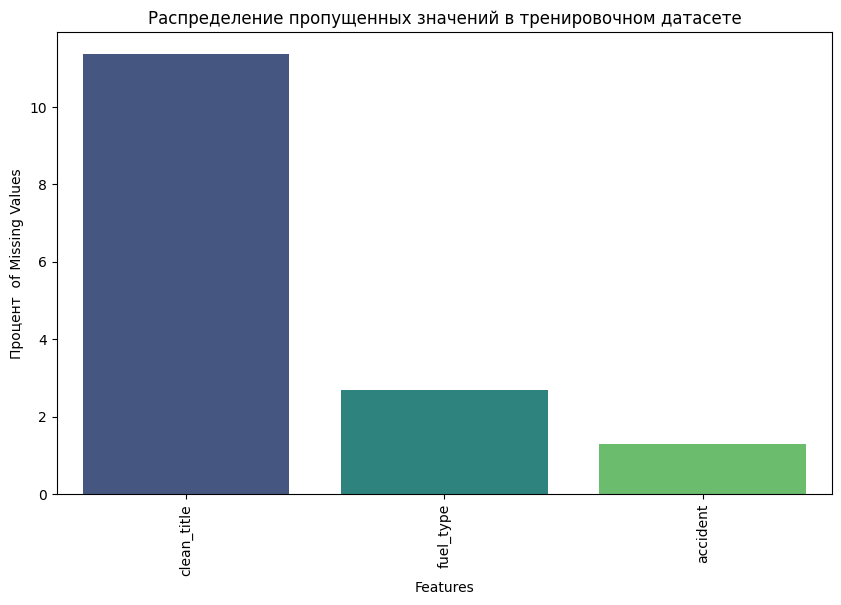

In [63]:
missing_values = df_train.isnull().mean() * 100
missing_values = missing_values[missing_values >0]
missing_values = missing_values.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Процент  of Missing Values')
plt.title('Распределение пропущенных значений в тренировочном датасете')
plt.show()

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import category_encoders as ce
from dython.nominal import associations

In [23]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)
sample_data = preprocess_data(sample_data)

#### Посмотрим на корреляционную матрицу

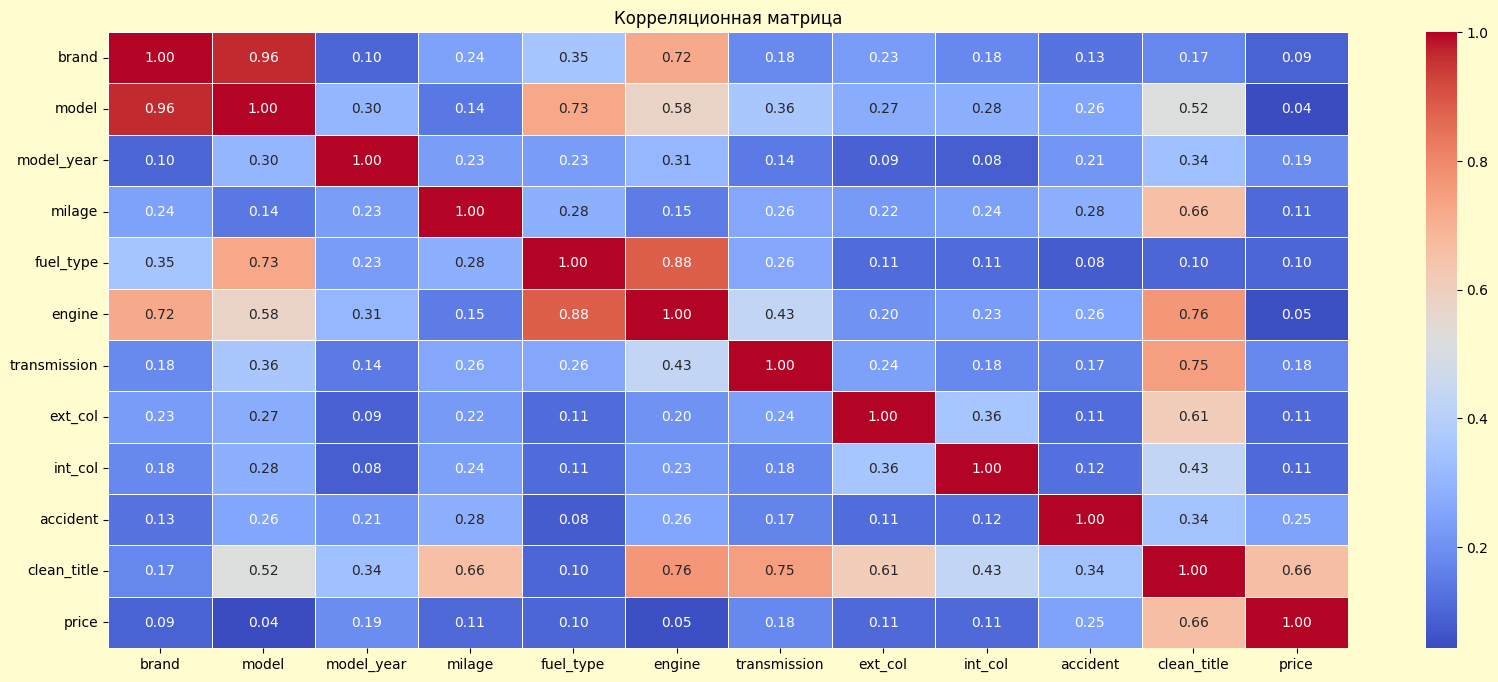

In [69]:
associations_df = associations(df_train, nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']
plt.figure(figsize=(20, 8))
plt.gcf().set_facecolor('#FFFDD0') 
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

#### Заполним пропуски в данных по методы k ближайших соседей

In [70]:
from sklearn.impute import KNNImputer

def knn_impute(df, n_neighbors=5):   
    df_encoded = df.copy()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)
    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(
            dict(enumerate(df[col].astype('category').cat.categories)))
    return df_imputed

In [71]:
df_train_imputed = knn_impute(df_train, n_neighbors=25)
df_test_imputed = knn_impute(df_test, n_neighbors=25)

In [72]:
cat_cols_train = df_train_imputed.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'class']
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

df_train_imputed[cat_cols_train] = ordinal_encoder.fit_transform(df_train_imputed[cat_cols_train].astype(str))
df_test_imputed[cat_cols_train] = ordinal_encoder.transform(df_test_imputed[cat_cols_train].astype(str))

In [73]:
df_train_imputed.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,31.0,495.0,2007.0,213000.0,2.0,116.0,38.0,312.0,71.0,1.0,0.0,4200.0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,0.0,4999.0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,0.0,13900.0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,0.0,45000.0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,0.0,97500.0


In [74]:
df_test_imputed.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,26.0,1390.0,2015.0,98000.0,2.0,325.0,16.0,304.0,10.0,1.0,0.0
1,26.0,1377.0,2020.0,9142.0,3.0,787.0,31.0,263.0,14.0,1.0,0.0
2,14.0,636.0,2022.0,28121.0,2.0,540.0,3.0,304.0,57.0,1.0,1.0
3,3.0,182.0,2016.0,61258.0,2.0,192.0,39.0,261.0,14.0,1.0,1.0
4,3.0,181.0,2018.0,59000.0,2.0,364.0,38.0,128.0,14.0,1.0,0.0


In [75]:
df_train = df_train_imputed
df_test = df_test_imputed

In [76]:
df_train.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [77]:
df_train['engine_transmission'] = df_train['engine'] * df_train['transmission']
df_test['engine_transmission'] = df_test['engine'] * df_test['transmission']

Добавим некоторые новые признаки для лучшего предсказания

In [78]:
urrent_year = 2024
luxury_brands = ['Mercedes-Benz', 'BMW', 'Audi', 'Lexus', 'Tesla']


def create_features(df):  
    df['rare_fuel_type'] = df['fuel_type'].apply(lambda x: 0 if x in ['Petrol', 'Diesel'] else 1)
    df['is_automatic'] = df['transmission'].apply(lambda x: 1 if x == 'Automatic' else 0)
    df['has_accident_history'] = df['accident'].apply(lambda x: 1 if x != 'Unknown' and x != 'None' else 0)
    df['color_match'] = df.apply(lambda row: 1 if row['ext_col'] == row['int_col'] else 0, axis=1)
    df['is_luxury_brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)
    return df

Сделаем удаление выбросов из данных с использованием метода межквартильного размаха

In [79]:
def remove_outliers_iqr(df, column):   
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1   
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR    
    df_out = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_out

df_train_no_outliers = remove_outliers_iqr(df_train, 'milage')
df_train_no_outliers = remove_outliers_iqr(df_train_no_outliers, 'price')
df_train_no_outliers.reset_index(drop=True, inplace=True)

In [80]:
df_train

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,engine_transmission
0,31.0,495.0,2007.0,213000.0,2.0,116.0,38.0,312.0,71.0,1.0,0.0,4200.0,4408.0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,0.0,4999.0,13908.0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,0.0,13900.0,24320.0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,0.0,45000.0,42287.0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,0.0,97500.0,5957.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,8.0,604.0,2017.0,49000.0,2.0,866.0,49.0,304.0,10.0,1.0,0.0,27500.0,42434.0
188529,36.0,206.0,2018.0,28600.0,2.0,770.0,31.0,304.0,14.0,0.0,0.0,30000.0,23870.0
188530,36.0,223.0,2021.0,13650.0,2.0,921.0,23.0,304.0,14.0,1.0,0.0,86900.0,21183.0
188531,3.0,1471.0,2022.0,13895.0,2.0,512.0,1.0,82.0,14.0,1.0,1.0,84900.0,512.0


In [82]:
df_train_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175900 entries, 0 to 175899
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   brand                175900 non-null  float64
 1   model                175900 non-null  float64
 2   model_year           175900 non-null  float64
 3   milage               175900 non-null  float64
 4   fuel_type            175900 non-null  float64
 5   engine               175900 non-null  float64
 6   transmission         175900 non-null  float64
 7   ext_col              175900 non-null  float64
 8   int_col              175900 non-null  float64
 9   accident             175900 non-null  float64
 10  clean_title          175900 non-null  float64
 11  price                175900 non-null  float64
 12  engine_transmission  175900 non-null  float64
dtypes: float64(13)
memory usage: 17.4 MB


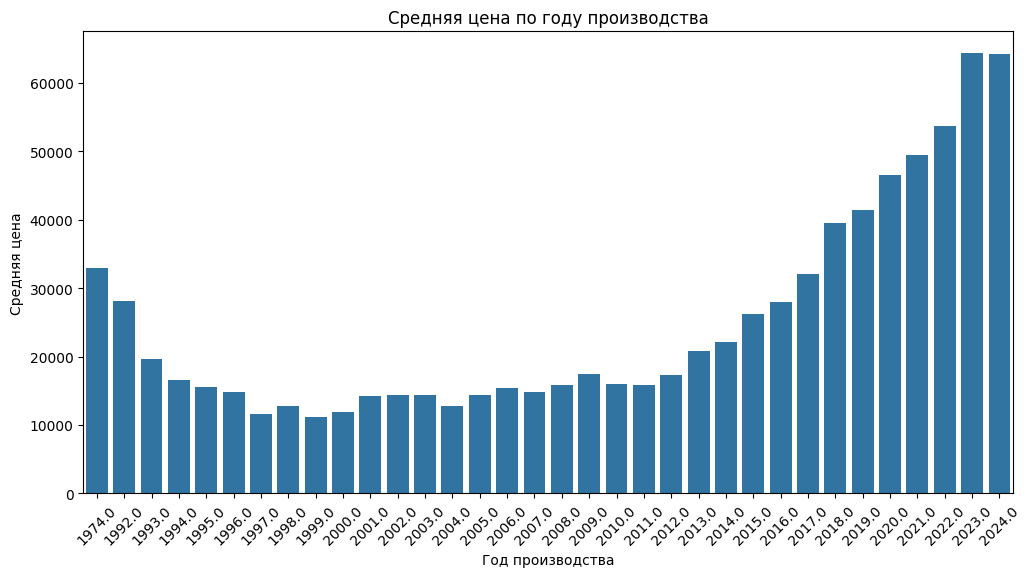

In [84]:
plt.figure(figsize=(12, 6))
sns.barplot(x='model_year', y='price', data=df_train_no_outliers, errorbar=None)
plt.title('Средняя цена по году производства')
plt.xlabel('Год производства')
plt.ylabel('Средняя цена')
plt.xticks(rotation=45)
plt.show()

## Моделирование

In [85]:
y = df_train['price'] 
X = df_train.drop(['price'],axis=1)

In [86]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(X)
scaled_test_data = scaler.transform(df_test)

In [87]:
n_splits = 4
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

lgb_params = {
    'boosting_type': 'gbdt', 
    'n_estimators':3500, 
    'learning_rate' :  0.012454128934012,    
    'num_leaves' : 250, 
    'subsample_for_bin': 165700, 
    'min_child_samples': 100, 
    'reg_alpha': 2.0755656e-06, 
    'reg_lambda': 3.832327874559e-07, 
    'colsample_bytree': 0.9634111975534,
    
    'subsample': 0.952378745109892, 
    'max_depth': 10,
    'random_state':0,
    'verbosity':-1
}


lgbm_predictions = np.zeros(len(scaled_train_data))
lgbm_true_labels = np.zeros(len(scaled_train_data))
lgbm_test_predictions = np.zeros(len(scaled_test_data))


for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")
    
    X_train, X_val = scaled_train_data[train_idx], scaled_train_data[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lgbm_model = LGBMRegressor(**lgb_params)

    lgbm_model.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                   eval_metric='rmse',         
                  )

    
    lgbm_fold_preds = lgbm_model.predict(X_val)
    lgbm_fold_test_preds = lgbm_model.predict(scaled_test_data)

    lgbm_predictions[val_idx] = lgbm_fold_preds
    lgbm_true_labels[val_idx] = y_val
    lgbm_test_predictions += lgbm_fold_test_preds / n_splits 
    fold_rmse = np.sqrt(mean_squared_error(y_val, lgbm_fold_preds))
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

overall_rmse_lgbm = np.sqrt(mean_squared_error(lgbm_true_labels, lgbm_predictions))
print(f"Overall RMSE (LGBMRegressor): {overall_rmse_lgbm:.4f}")

Training fold 1/4...
Fold 1 RMSE: 66269.0454
Training fold 2/4...
Fold 2 RMSE: 79009.5424
Training fold 3/4...
Fold 3 RMSE: 73326.0515
Training fold 4/4...
Fold 4 RMSE: 75472.1071
Overall RMSE (LGBMRegressor): 73666.1744


In [91]:
xgb_params = {
 'lambda': 0.17694956261235095,
 'alpha': 1.3889763984339085,
 'colsample_bytree': 0.7,
 'subsample': 1.0,
 'learning_rate': 0.008,
 'max_depth': 17,
 'random_state': 2024,
 'min_child_weight': 59,
 'n_estimators': 400,    
 'device': "cuda"
}

n_splits = 4
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

xgb_predictions = np.zeros(len(scaled_train_data))
xgb_true_labels = np.zeros(len(scaled_train_data))
xgb_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")
    
    X_train, X_val = scaled_train_data[train_idx], scaled_train_data[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    xgb_model = XGBRegressor(**xgb_params, eval_metric='rmse',  early_stopping_rounds=10) 
    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  # eval_metric='rmse',
                 
                  verbose=False)

    xgb_fold_preds = xgb_model.predict(X_val)
    xgb_fold_test_preds = xgb_model.predict(scaled_test_data)
    xgb_predictions[val_idx] = xgb_fold_preds
    xgb_true_labels[val_idx] = y_val
    xgb_test_predictions += xgb_fold_test_preds / n_splits  

    fold_rmse = np.sqrt(mean_squared_error(y_val, xgb_fold_preds))
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

overall_rmse_xgb = np.sqrt(mean_squared_error(xgb_true_labels, xgb_predictions))
print(f"Overall RMSE (XGBRegressor): {overall_rmse_xgb:.4f}")


Training fold 1/4...
Fold 1 RMSE: 65396.0929
Training fold 2/4...
Fold 2 RMSE: 78078.1376
Training fold 3/4...
Fold 3 RMSE: 72720.9706
Training fold 4/4...
Fold 4 RMSE: 74641.9183
Overall RMSE (XGBRegressor): 72857.0144


In [92]:
xgb_test_predictions

array([19053.52001953, 82080.39257812, 57411.74707031, ...,
       23082.03515625, 17682.82470703, 35417.97851562])

In [93]:
lgbm_test_predictions

array([16503.41296734, 91911.2832409 , 63745.79575457, ...,
       22796.970184  , 15628.44318656, 36365.9175096 ])

In [94]:
df_sub['price']= lgbm_test_predictions*0.2+xgb_test_predictions*0.8

### Сохранение результатов

In [95]:
df_sub.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv')

,id,price
0,188533,18543.498609
1,188534,84046.570711
2,188535,58678.556807
3,188536,24915.577098
4,188537,29320.117820
...,...,...
125685,314218,30249.100824
125686,314219,49399.359424
125687,314220,23025.022162
125688,314221,17271.948403
